# Assignment 1

## Part 2. Scalar backpropogation

### Question 3

Scalar backpropogation - meaning it is calculated and applied element-wise.

In [1]:
import math
from random import gauss, uniform

In [2]:
def transpose(lst):
    return list(map(list, zip(*lst)))

In [3]:
def init_weights(is_random=True, mean=0, std=1):
    """
     Initialise weights and biases

    Args:
        is_random (bool, optional): Should . Defaults to True.
        mean (int, optional): _description_. Defaults to 0.
        std (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: _description_
    """
    if is_random:
        # W1 = [[gauss(mean, std) for _ in range(3)] for _ in range(2)]
        # W2 = [[gauss(mean, std) for _ in range(2)] for _ in range(3)]
        W1 = [[uniform(-1, 1) for _ in range(3)] for _ in range(2)]
        W2 = [[uniform(-1, 1) for _ in range(2)] for _ in range(3)]
    else:
        W1 = [
            [1, 1, 1],
            [-1, -1, -1]
        ]
        W2 = [
            [1, 1],
            [-1, -1],
            [-1, -1]
        ]
    b1, b2 = [0, 0, 0], [0, 0]

    return (W1, b1), (W2, b2)

In [4]:
def linear(x, W, b):
    """
    Compute linear transformation.
    """
    W = transpose(W)

    Wx = []
    for Wi, bi in zip(W, b):
        Wx.append(sum([w*x for w, x in zip(Wi, x)]) + bi)

    return Wx


In [5]:
def sigmoid(x):
    """
    Calculate sigmoid
    """
    return 1 / (1 + math.exp(-x))

In [6]:
def sigmoid_backward(output):
    """
    Compute derivative for sigmoid function
    """
    # deriv = [[0 for _ in range(len(output))] for _ in range(len(output))]
    # for i in range(len(output)):
    #     deriv[i][i] = output[i]*(1 - output[i])
    # return deriv
    return [val*(1 - val) for val in output]

In [7]:
def softmax(x):
    """
    Calculate softmax
    """
    x_norm = [val - min(x) for val in x]
    x_exp = [math.exp(val) for val in x_norm]
    sum_exp = sum(x_exp)

    return [val/sum_exp for val in x_exp]

In [8]:
def softmax_backward(output):
    """ 
    Calculate dsoftmax(x)/dx
    """
    deriv = []
    for i in range(len(output)):
        deriv.append([-p*output[i] for p in output])
        deriv[i][i] = output[i]*(1 - output[i])

    return deriv

In [9]:
def loss(output, target):
    return -math.log(output[target])

In [10]:
def loss_backward(output, target):
    """ 
    Calculate dl/dy

    Args:
        pros (list): list of probabilities for classes
        y_pred (int): predicted class
    """

    deriv = [0 for _ in output]
    deriv[target] = - 1./output[target]

    return deriv

Check derivatives for loss with respect to weights and biases.

In [11]:
from copy import deepcopy

In [12]:
def forward_backward(input, target, W1, b1, W2, b2):
    # forward pass
    h1 = linear(input, W1, b1)
    a1 = [sigmoid(h_) for h_ in h1]
    h2 = linear(a1, W2, b2)
    output = softmax(h2)

    l = loss(output, target)

    # backward pass
    dl_do = loss_backward(output, target)
    do_dh2 = softmax_backward(output)

    dl_dh2 = []
    for o_hi in transpose(do_dh2):
        dl_dh2.append(sum([l_oj*oj_hi for l_oj, oj_hi in zip(dl_do, o_hi)]))
    
    dl_da1 = []
    for row in W2:
        dl_da1.append(sum([l_h2 * w for l_h2, w in zip(dl_dh2, row)]))

    dl_dw2 = deepcopy(W2)
    for i in range(len(W2)):
        for j in range(len(W2[i])):
            dl_dw2[i][j] = a1[i]*dl_dh2[j]
    
    dl_db2 = dl_dh2

    da1_dh1 = sigmoid_backward(a1)
    dl_dh1 = [l_a*a_h for l_a, a_h in zip(dl_da1, da1_dh1)]

    dl_dw1 = deepcopy(W1)
    for i in range(len(W1)):
        for j in range(len(W1[i])):
            dl_dw1[i][j] = input[i]*dl_dh1[j]
    
    dl_db1 = dl_dh1

    return output, l, dl_dw1, dl_db1, dl_dw2, dl_db2

In [13]:
input=[1, -1]
target = 0
(W1, b1), (W2, b2) = init_weights(is_random=False)

probs, l, dl_dw1, dl_db1, dl_dw2, dl_db2 = forward_backward(input, target, W1, b1, W2, b2)

In [14]:
dl_dw1, dl_db1

([[0.0, 0.0, 0.0], [-0.0, -0.0, -0.0]], [0.0, 0.0, 0.0])

In [15]:
dl_dw2, dl_db2

([[-0.44039853898894116, 0.44039853898894116],
  [-0.44039853898894116, 0.44039853898894116],
  [-0.44039853898894116, 0.44039853898894116]],
 [-0.5, 0.5])

### Question 4

In [16]:
from data import load_synth
from sklearn.metrics import accuracy_score

In [17]:
(xtrain, ytrain), (xval, yval), num_cls = load_synth()
print(xtrain.shape, ytrain.shape, xval.shape, yval.shape, num_cls) 

(60000, 2) (60000,) (10000, 2) (10000,) 2


In [18]:
import matplotlib.pyplot as plt

def draw_curve(niter, losses, val_losses, title, ylim=None, xlabel=None, ylabel=None):
    fig = plt.figure(figsize=(7, 5))
    plt.plot(range(1, niter+1), losses, 'bo-', label='train')
    plt.plot(range(1, niter+1), val_losses, 'ro-', label='val')
    plt.legend(loc='upper left')
    plt.grid()
    if ylim is not None:
        plt.ylim(ylim)

    if xlabel is not None:
        plt.xlabel(xlabel)

    if ylabel is not None:
        plt.ylabel(ylabel)

    fig.savefig(f'./images/{title}.jpg')

In [19]:
def train(X, y, X_val, y_val, W1, b1, W2, b2, learning_rate=0.01, niter=10):
    
    losses = []
    acc = []
    val_losses = []
    val_acc = []

    for iter in range(niter):
        # learning loop
        for x_, y_ in zip(X, y):
            _, _, dl_dw1, dl_db1, dl_dw2, dl_db2 = forward_backward(x_, y_, W1, b1, W2, b2)

            for i in range(len(W2)):
                for j in range(len(W2[i])):
                    W2[i][j] -= learning_rate*dl_dw2[i][j]

            for i in range(len(b2)):
                b2[i] -= learning_rate*dl_db2[i]

            for i in range(len(W1)):
                for j in range(len(W1[i])):
                    W1[i][j] -= learning_rate*dl_dw1[i][j]

            for i in range(len(b1)):
                b1[i] -= learning_rate*dl_db1[i]

        # validation loops
        total_loss = 0
        y_pred = []
        for x_, y_ in zip(X, y):
            output, l, _, _, _, _ = forward_backward(x_, y_, W1, b1, W2, b2)
            total_loss += l
            y_pred.append(output.index(max(output)))
        losses.append(total_loss/len(X))
        acc.append(accuracy_score(y, y_pred))


        total_val_loss = 0
        y_pred = []
        for x_, y_ in zip(X_val, y_val):
            output, l, _, _, _, _ = forward_backward(x_, y_, W1, b1, W2, b2)
            total_val_loss += l
            y_pred.append(output.index(max(output)))
        val_losses.append(total_val_loss/len(X_val))
        val_acc.append(accuracy_score(y_val, y_pred))

        print(f'Iter {iter} - train loss = {losses[iter]:.6f} - train acc = {acc[iter]:.2f} - val loss = {val_losses[iter]:.6f} - val acc = {val_acc[iter]:.2f}')
    
    draw_curve(niter, losses, val_losses, 'Loss', xlabel='epoch', ylabel='loss')
    
    return losses, val_losses, (W1, b1), (W2, b2)

Iter 0 - train loss = 0.192120 - train acc = 0.94 - val loss = 0.193551 - val acc = 0.94
Iter 1 - train loss = 0.119127 - train acc = 0.97 - val loss = 0.119007 - val acc = 0.97
Iter 2 - train loss = 0.105461 - train acc = 0.97 - val loss = 0.104968 - val acc = 0.98
Iter 3 - train loss = 0.097781 - train acc = 0.98 - val loss = 0.097089 - val acc = 0.98
Iter 4 - train loss = 0.091219 - train acc = 0.98 - val loss = 0.090171 - val acc = 0.98
Iter 5 - train loss = 0.085708 - train acc = 0.98 - val loss = 0.084278 - val acc = 0.98
Iter 6 - train loss = 0.081110 - train acc = 0.98 - val loss = 0.079420 - val acc = 0.98
Iter 7 - train loss = 0.077257 - train acc = 0.98 - val loss = 0.075417 - val acc = 0.99
Iter 8 - train loss = 0.073989 - train acc = 0.98 - val loss = 0.072068 - val acc = 0.99
Iter 9 - train loss = 0.071176 - train acc = 0.98 - val loss = 0.069217 - val acc = 0.99
Iter 10 - train loss = 0.068724 - train acc = 0.99 - val loss = 0.066752 - val acc = 0.99
Iter 11 - train loss

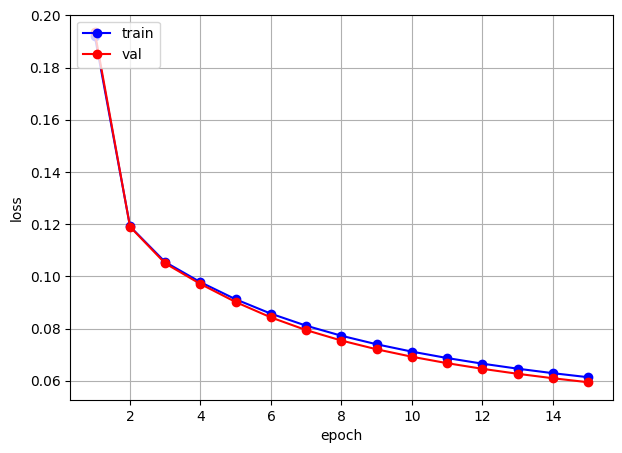

In [20]:
(W1, b1), (W2, b2) = init_weights()
losses, val_losses, _, _ = train(xtrain, ytrain, xval, yval, W1, b1, W2, b2, niter=15)

## Part 3 - Tensor backpropogation

### Question 5

In [21]:
import numpy as np
from time import time
from IPython.display import clear_output
from data import load_mnist

In [22]:
class Layer:
    def __init__(self) -> None:
        self.name = 'layer'
        self.input_size = None
        self.output_size = None
        self.training = True

    def forward(self, input):
        return input

    def backward(self, input, gradient):
        return gradient

    def update_parameters(self, learning_rate):
        pass

    def zero_grad_parameters(self):
        pass

    def train(self):
        self.training = True

    def evaluate(self):
        self.training = False



In [23]:
class Linear(Layer):
    def __init__(self, input_size, output_size, name='linear') -> None:
        super().__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.name = name

        self.W = np.random.normal(size=(input_size, output_size))
        self.b = np.random.normal(size=(1, output_size))

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def forward(self, input):
        self.output = np.dot(input, self.W) + self.b
        return self.output

    def backward(self, input, gradient):
        self.grad_input = np.dot(gradient, self.W.T)
        self.gradW = np.dot(input.T, gradient)
        self.gradb = np.sum(gradient, axis=0).reshape((1, -1))

        return self.grad_input

    def update_parameters(self, learning_rate=0.01):
        self.W = self.W - learning_rate * self.gradW
        self.b = self.b - learning_rate * self.gradb

    def zero_grad_parameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
        

    

In [24]:
class Sigmoid(Layer):
    def __init__(self, name='sigmoid') -> None:
        super().__init__()
        self.name = name

    def forward(self, input):
        self.output = 1/(1 + np.exp(-input))
        return self.output

    def backward(self, input, gradient):
        self.grad_input = self.output * (1 - self.output) * gradient
        return self.grad_input

In [25]:
class Softmax(Layer):
    def __init__(self, name='softmax') -> None:
        super().__init__()
        self.name = name

    def forward(self, input):
        input = np.subtract(input, input.max(axis=1, keepdims=True))
        denom = np.sum(np.exp(input), axis=1)
        denom = np.repeat(denom[..., np.newaxis], input.shape[-1], axis=-1)
        self.output = np.exp(input) / denom
        return self.output

    def backward(self, input, gradient):
        # transform formula and each element can be count as o_i *(dl/do_i - sum_k (o_k * dl_do_k))
        grad = np.sum(gradient * self.output, axis=-1) #  sum_k (o_k * dl_do_k)
        grad = np.repeat(grad[..., np.newaxis], gradient.shape[-1], axis=-1)
        grad = gradient - grad
        self.grad_input = grad * self.output
        return self.grad_input

In [26]:
class Network:
    def __init__(self, name='model') -> None:
        self.name = name
        self.layers = []
        self.training = True

    def add(self, layer):
        self.layers.append(layer)

    def train(self):
        for layer in self.layers:
            layer.train()

    def evaluate(self):
        for layer in self.layers:
            layer.evaluate()

    def update_parameters(self, learning_rate):
        if self.training:
            for layer in self.layers:
                layer.update_parameters(learning_rate)

    def zero_grad_parameters(self):
        for layer in self.layers:
            layer.zero_grad_parameters()

    def forward(self, input):
        self.output = input
        for layer in self.layers:
            self.output = layer.forward(self.output)
        
        return self.output

    def backward(self, input, gradient):
        self.grad_input = gradient
        ind = len(self.layers) - 1

        for layer in self.layers[::-1]:
            if ind == 0:
                self.grad_input = layer.backward(input, self.grad_input)
            else:
                # output from previous layer is an input to this layer
                self.grad_input = layer.backward(self.layers[ind-1].output, self.grad_input)
                ind -= 1
        return self.grad_input


In [27]:
class NegLogLikelihoodLoss:
    def __init__(self) -> None:
        self.eps = 1e-15 # avoiding log of zero

    def compute(self, output, target):
        batch_size = output.shape[0]
        output = np.clip(output, self.eps, 1-self.eps)
        self.output = np.sum(-np.log(np.sum(output * target, axis=1))) / batch_size
        return self.output

    def backward(self, output, target):
        batch_size = output.shape[0]
        output = np.clip(output, self.eps, 1-self.eps)
        self.grad_input = - 1 / (output * batch_size) * target
        return self.grad_input

In [28]:
def normalize(X, min=0, max=255):
    return (X - min) / (max - min)


def do_one_hot_target(target, shape):
    one_hot_target = np.zeros(shape)
    np.put_along_axis(one_hot_target, np.expand_dims(target, axis=1), 1, axis=-1)
    return one_hot_target


def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

In [29]:
def create_model(input_size, hidden_size, output_size):
    model = Network("Model")
    model.add(Linear(input_size, hidden_size, "Linear1"))
    model.add(Sigmoid('Sigmoid'))
    model.add(Linear(hidden_size, output_size, "Linear2"))
    model.add(Softmax('Softmax'))
    return model

In [30]:
def experiment(model, loss, x_train, y_train, x_val, y_val, n_epoch=25, batch_size=256, learning_rate=0.01):
    train_losses = []
    train_acc = []
    val_losses = []
    val_acc = []
    loss_history = []

    for i in range(n_epoch):
        model.train()
        start_time = time()

        epoch_loss = []
        y_pred = 0
        for x_batch, y_batch in get_batches((x_train, y_train), batch_size):
            model.zero_grad_parameters()
            
            # Forward
            predictions = model.forward(x_batch)
            l = loss.compute(predictions, y_batch)
            # Backward
            grad = loss.backward(predictions, y_batch)
            model.backward(x_batch, grad)

            model.update_parameters(learning_rate)

            epoch_loss.append(l)
            y_pred += np.sum(np.argmax(y_batch, axis=-1) == np.argmax(predictions, axis=-1))
        finish_time = time()
        train_losses.append(np.mean(epoch_loss))
        train_acc.append(y_pred/len(y_train))
        loss_history.extend(epoch_loss)

        model.evaluate()

        total_val_loss = []
        y_pred = 0
        for x_batch, y_batch in get_batches((x_val, y_val), batch_size):
            predictions = model.forward(x_batch)
            l = loss.compute(predictions, y_batch)
            total_val_loss.append(l)
            y_pred += np.sum(np.argmax(y_batch, axis=-1) == np.argmax(predictions, axis=-1))
        val_losses.append(np.mean(total_val_loss))
        val_acc.append(y_pred/len(y_val))

        clear_output(wait=True)
        print(f'Epoch {i+1}: loss={np.mean(epoch_loss)}, elapsed time={finish_time - start_time:.4f}')

        # Visualize
        plt.figure(figsize=(8, 6))

        plt.title("Training loss")
        plt.xlabel("timestamp")
        plt.ylabel("loss")
        plt.grid()
        plt.plot(loss_history, 'b')
        plt.show()

    metrics = {
        'train_losses': train_losses,
        'train_acc': train_acc,
        'val_losses': val_losses,
        'val_acc': val_acc,
        'loss_history': loss_history
    }
    
    return model, metrics


In [31]:
input_size = 784
output_size = 10
hidden_size = 300

In [32]:
load_mnist()

((array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  array([5, 0, 4, ..., 0, 4, 0], dtype=uint8)),
 (array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  array([1, 2, 8, ..., 5, 6, 8], dtype=uint8)),
 10)

In [33]:
(x_train, t_train), (x_test, t_test), n_cls = load_mnist()
x_train = normalize(x_train)
x_test = normalize(x_test)
y_train_ohe = do_one_hot_target(t_train, (len(t_train), 10))
y_test_ohe = do_one_hot_target(t_test, (len(t_test), 10))

In [34]:
x_train.shape, x_test.shape

((55000, 784), (5000, 784))

In [35]:
from collections import Counter

Counter(t_train)

Counter({5: 4963,
         0: 5434,
         4: 5343,
         1: 6212,
         9: 5466,
         2: 5465,
         3: 5622,
         6: 5436,
         7: 5702,
         8: 5357})

Epoch 25: loss=1.1268300623760985, elapsed time=1.9531


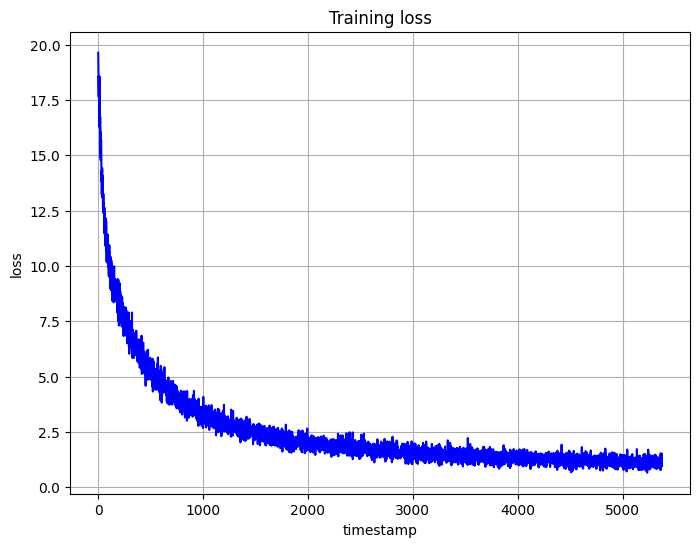

In [36]:
model = create_model(input_size, hidden_size, output_size)
nll_loss = NegLogLikelihoodLoss()
model, metrics = experiment(model, nll_loss, x_train, y_train_ohe, x_test, y_test_ohe)

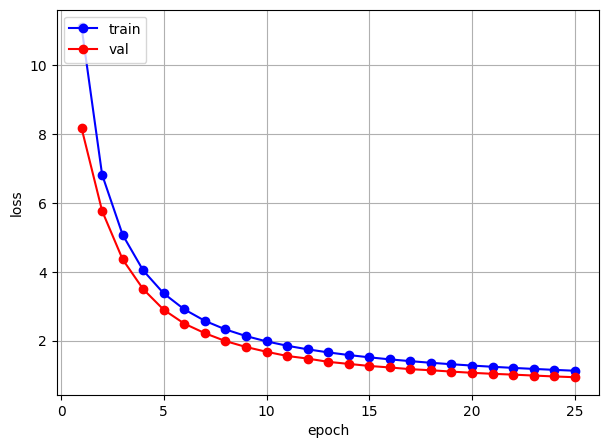

In [37]:
draw_curve(25, metrics['train_losses'], metrics['val_losses'], 'loss', xlabel='epoch', ylabel='loss')

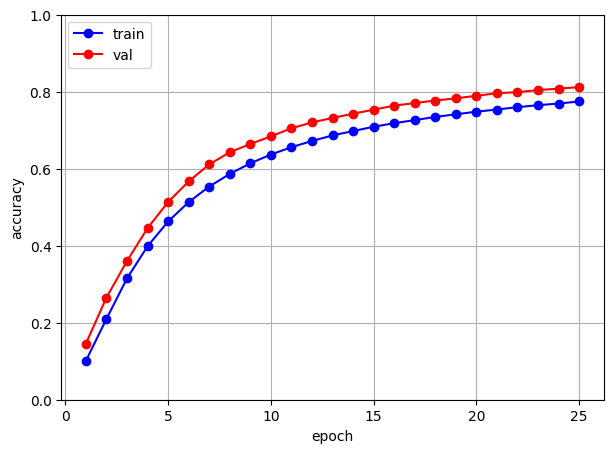

In [38]:
draw_curve(25, metrics['train_acc'], metrics['val_acc'], 'accuracy', ylim=(0, 1), xlabel='epoch', ylabel='accuracy')

## Part 4 - Analysis

### Question 7

1. Compare the training loss per epoch to the validation loss per epoch. What does the
difference tell you?

Epoch 5: loss=2.821362393048467, elapsed time=1.6922


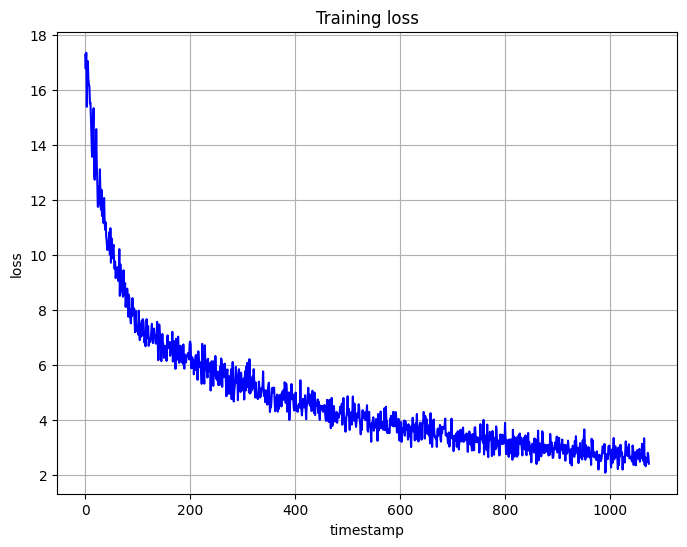

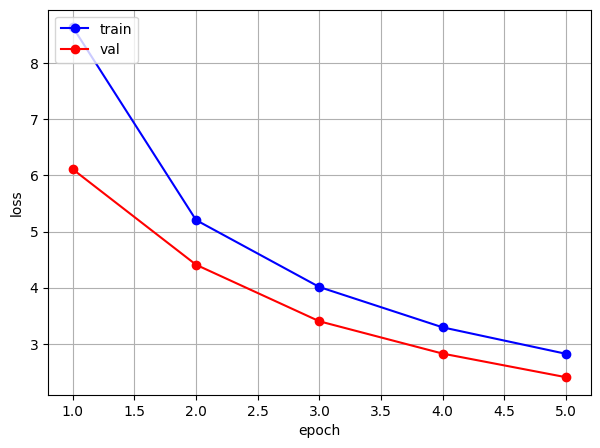

In [39]:
model = create_model(input_size, hidden_size, output_size)
nll_loss = NegLogLikelihoodLoss()
model, metrics = experiment(model, nll_loss, x_train, y_train_ohe, x_test, y_test_ohe, n_epoch=5)
draw_curve(5, metrics['train_losses'], metrics['val_losses'], 'loss', xlabel='epoch', ylabel='loss')

Train the neural network from a random initialization multiple times (at least 3) and
plot an average and a standard deviation of the objective value in each iteration 3
(e.g., see: here). What does this tell you?

Epoch 5: loss=4.4792215781177145, elapsed time=1.4688


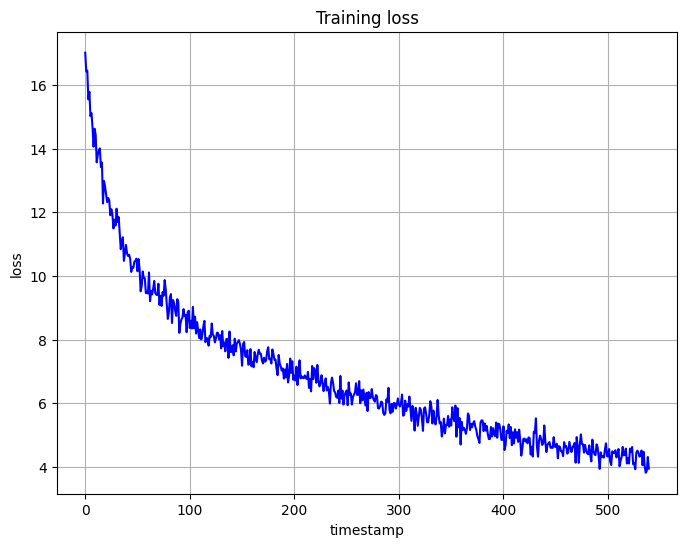

In [40]:
nll_loss = NegLogLikelihoodLoss()

losses_per_iter = []
for i in range(5):
    model = create_model(input_size, hidden_size, output_size)
    _, metrics = experiment(model, nll_loss, x_train, y_train_ohe, x_test, y_test_ohe, n_epoch=5, batch_size=512)
    losses_per_iter.append(metrics['loss_history'][::3])

In [41]:
import seaborn as sns

In [42]:
def draw_curve_w_error(data, title='Loss meand +- std interval'):
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)

    fig = plt.figure(figsize=(7, 5))
    sns.lineplot(x=range(1, len(means)+1), y=means)
    plt.fill_between(range(1, len(means)+1), means - stds, means + stds, alpha=0.5)
    # plt.legend(loc='upper left')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.title(title)
    plt.grid()

    fig.savefig(f'./images/{title}.jpg')
    

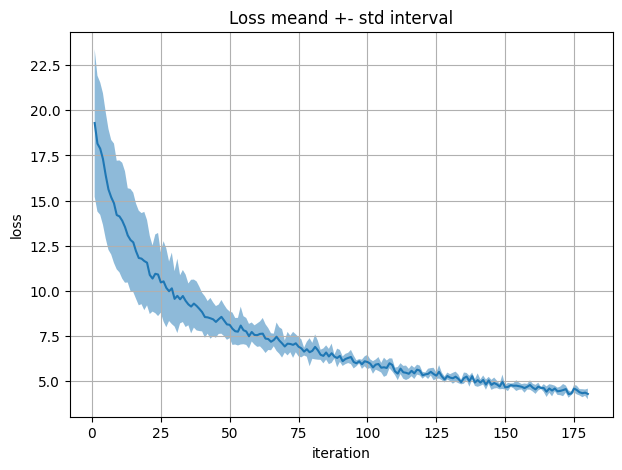

In [43]:
losses_per_iter = np.array(losses_per_iter)
draw_curve_w_error(losses_per_iter)

Run the SGD with different learning rates (e.g., 0.001, 0.003, 0.01, 0.03). Analyze
how the learning rate value influences the final performance.

Epoch 5: loss=0.8296265500237202, elapsed time=3.6860


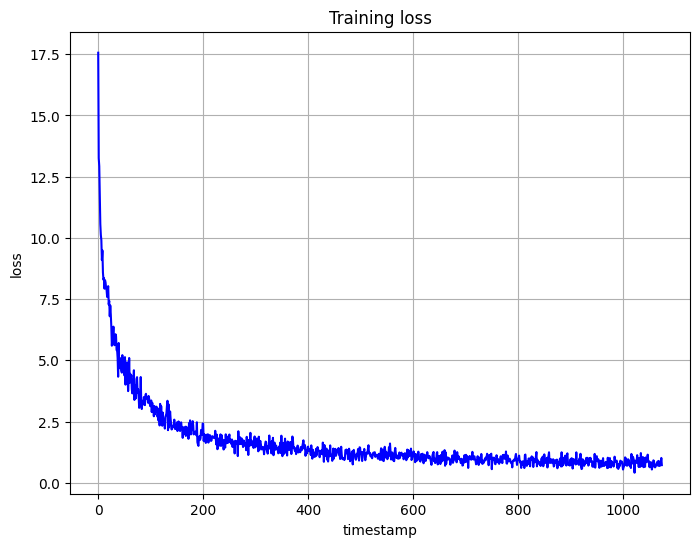

In [44]:
l_r_losses = []
for l_r in [0.001, 0.003, 0.01, 0.03, 0.1]:
    model = create_model(input_size, hidden_size, output_size)
    _, metrics = experiment(model, nll_loss, x_train, y_train_ohe, x_test, y_test_ohe, n_epoch=5, batch_size=256, learning_rate=l_r)
    l_r_losses.append(metrics['loss_history'])

In [45]:
def draw_curve_per_l_r(data, title='Loss for different learning_rate values'):
    fig = plt.figure(figsize=(7, 5))
    for i, l_r in enumerate([0.001, 0.003, 0.01, 0.03, 0.1]):
        sns.lineplot(x=range(1, len(data[i])+1), y=data[i], label=f'{l_r}')
    plt.legend(loc='upper left')
    plt.title(title)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.grid()

    fig.savefig(f'./images/{title}.jpg')

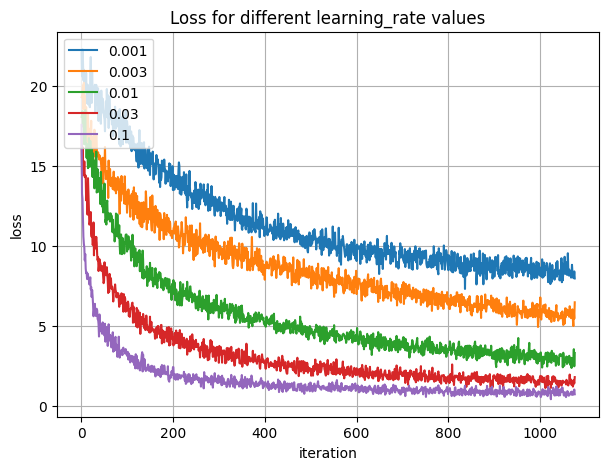

In [46]:
l_r_losses = np.array(l_r_losses)
draw_curve_per_l_r(l_r_losses)

Based on these experiments, choose a final set of hyperparameters. Then load the
full training data with the canonical test set, train your model with the chosen
hyperparameters and report the accuracy you get.

In [47]:
def train(model, loss, x_train, y_train, n_epoch=25, batch_size=256, learning_rate=0.01):
    train_acc = []
    loss_history = []

    for i in range(n_epoch):
        model.train()
        start_time = time()

        epoch_loss = []
        y_pred = 0
        for x_batch, y_batch in get_batches((x_train, y_train), batch_size):
            model.zero_grad_parameters()
            
            # Forward
            predictions = model.forward(x_batch)
            l = loss.compute(predictions, y_batch)
            # Backward
            grad = loss.backward(predictions, y_batch)
            model.backward(x_batch, grad)

            model.update_parameters(learning_rate)

            epoch_loss.append(l)
            y_pred += np.sum(np.argmax(y_batch, axis=-1) == np.argmax(predictions, axis=-1))
        finish_time = time()
        train_acc.append(y_pred/len(y_train))
        loss_history.extend(epoch_loss)

        model.evaluate()

        print(f'Epoch {i+1}: loss={np.mean(epoch_loss)}, acc={train_acc[-1]}, elapsed time={finish_time - start_time:.4f}')

    metrics = {
        'train_acc': train_acc,
        'loss_history': loss_history
    }
    
    return model, metrics


In [48]:
(x_train, t_train), (x_test, t_test), n_cls = load_mnist(final=True) 
x_train = normalize(x_train)
x_test = normalize(x_test)
y_train_ohe = do_one_hot_target(t_train, (len(t_train), 10))
y_test_ohe = do_one_hot_target(t_test, (len(t_test), 10))

In [49]:
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [50]:
from collections import Counter

Counter(t_train)

Counter({5: 5421,
         0: 5923,
         4: 5842,
         1: 6742,
         9: 5949,
         2: 5958,
         3: 6131,
         6: 5918,
         7: 6265,
         8: 5851})

In [51]:
model = create_model(input_size, hidden_size, output_size)
nll_loss = NegLogLikelihoodLoss()
model, metrics = train(model, nll_loss, x_train, y_train_ohe, n_epoch=100, batch_size=128, learning_rate=0.03)

Epoch 1: loss=4.79811997416938, acc=0.39808333333333334, elapsed time=4.2616
Epoch 2: loss=1.898665525086426, acc=0.6709833333333334, elapsed time=4.3984
Epoch 3: loss=1.4252115802463197, acc=0.7403833333333333, elapsed time=4.6583
Epoch 4: loss=1.1987091660095028, acc=0.7750333333333334, elapsed time=5.1440
Epoch 5: loss=1.0586609780842824, acc=0.7972166666666667, elapsed time=4.2902
Epoch 6: loss=0.9607884685231646, acc=0.8142, elapsed time=4.7095
Epoch 7: loss=0.8869800415078914, acc=0.826, elapsed time=4.2818
Epoch 8: loss=0.8284944769024953, acc=0.8347, elapsed time=4.2879
Epoch 9: loss=0.780557414027074, acc=0.8430666666666666, elapsed time=4.3343
Epoch 10: loss=0.7409706742314289, acc=0.8495, elapsed time=4.1626
Epoch 11: loss=0.7060295625565998, acc=0.8548166666666667, elapsed time=5.1958
Epoch 12: loss=0.6752034377634393, acc=0.8596166666666667, elapsed time=4.4946
Epoch 13: loss=0.6484239280582417, acc=0.8643833333333333, elapsed time=2.4675
Epoch 14: loss=0.6241551364636302,

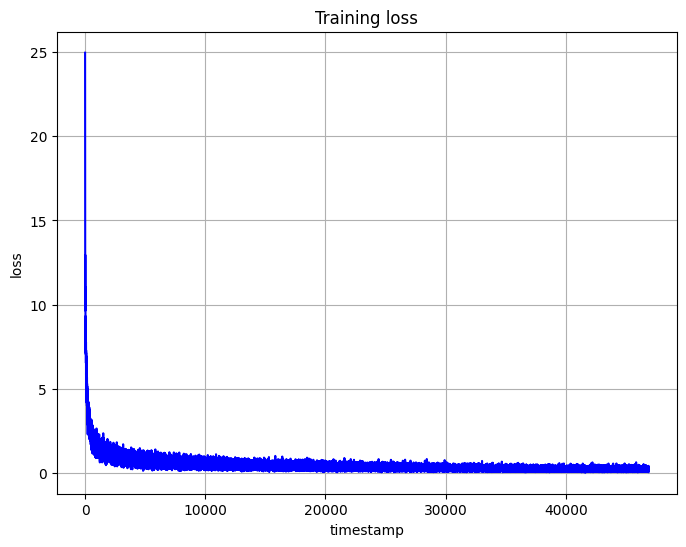

In [52]:
# Visualize
plt.figure(figsize=(8, 6))

plt.title("Training loss")
plt.xlabel("timestamp")
plt.ylabel("loss")
plt.grid()
plt.plot(metrics['loss_history'], 'b')
plt.show()

In [53]:
y_pred = 0
batch_size = 128
model.evaluate()

for x_batch, y_batch in get_batches((x_test, y_test_ohe), batch_size):
    predictions = model.forward(x_batch)
    y_pred += np.sum(np.argmax(y_batch, axis=-1) == np.argmax(predictions, axis=-1))
acc_score = y_pred / len(y_test_ohe)

In [54]:
acc_score

0.9221